# AR(1) process parameter estimation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

import keras
import tensorflow as tf
from tensorflow.python.keras import backend

In [2]:
config = tf.compat.v1.ConfigProto(device_count={'GPU': 1, 'CPU': 6})
sess = tf.compat.v1.Session(config=config)
backend.set_session(sess)

In [3]:
tf.debugging.set_log_device_placement(False)

In [4]:
np.random.seed(42)

In [5]:
tf.random.set_seed(42)

In [6]:
n = 2000

In [7]:
iter_count = 2000

In [8]:
parameter_count = 3

In [9]:
def generate_parameters():
    precision = .1
    variance = 1. / precision
    std = np.sqrt(variance)
    mu = np.random.normal(loc=0., scale=std)
    phistar = np.random.beta(a=20., b=1.5)
    itau2 = np.random.gamma(shape=2.5, scale=.025)
    beta = np.exp(.5 * mu)
    phi = 2. * phistar - 1.
    tau = np.sqrt(1. / itau2)
    return {'mu': mu, 'phi': phi, 'tau': tau}

In [10]:
def generate_xs(parameters, n):
    xs = []
    x0 = np.random.normal(loc=parameters['mu'], scale=parameters['tau'])
    xs.append(x0)
    for x in range(n):
        x_mean = parameters['mu'] + parameters['phi'] * (xs[-1] - parameters['mu'])
        x = np.random.normal(loc=x_mean, scale=parameters['tau'])
        xs.append(x)
    return np.array(xs)

In [11]:
parameters = {'mu': 2. * np.log(.7204), 'phi': .9807, 'tau': .1489}

In [12]:
xs = generate_xs(parameters, n)

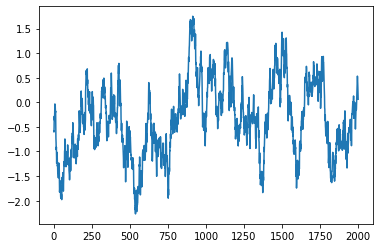

In [13]:
plt.plot(xs);

In [14]:
parameterss = []
for i in range(10000):
    parameters = generate_parameters()
    parameterss.append(tuple(parameters.values()))

In [15]:
min_parameters = np.min(parameterss, axis=0)
min_parameters

array([-12.85340372,   0.25282363,   1.80539699])

In [16]:
max_parameters = np.max(parameterss, axis=0)
max_parameters

array([11.18349505,  0.99965033, 31.85563994])

In [17]:
def min_max_scaler(new_input):
    return (new_input - tf.reduce_min(new_input, axis=1, keepdims=True)) / (tf.reduce_max(new_input, axis=1, keepdims=True) - tf.reduce_min(new_input, axis=1, keepdims=True)) - .5

In [18]:
inputs = keras.Input(shape=(n, 1))

x = keras.layers.Lambda(min_max_scaler)(inputs)
x = keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu')(x)
x = keras.layers.Flatten()(x)

y = keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu')(inputs)
y = keras.layers.Flatten()(y)

xy = keras.layers.add([x, y])

z = keras.layers.Dense(64, activation='relu')(xy)

outputs = keras.layers.Dense(parameter_count, activation='linear')(z)
model = keras.Model(inputs, outputs)

In [19]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [20]:
model.compile(loss='mse', optimizer=optimizer)

In [21]:
model.save('model.h5')

In [22]:
def train_model(model, n, batch_count, parameter=['mu', 'phi', 'tau'], scale_parameters=False):
    losses = []
    for i in range(iter_count):
        inputs = []
        outputs = []
        count = 0
        while count < 32:
            parameters = generate_parameters()
            xs = generate_xs(parameters, n)
            if np.min(xs) < -100. or np.max(xs) > 100.: continue
            count += 1
            xs = xs[1:]
            xs = (xs - (-100.)) / (100. - (-100.)) - .5
            an_input = np.zeros((n, 1))
            an_input[:,0] = xs
            inputs.append(an_input)
            an_output = np.array([parameters[param] for param in parameter])
            if scale_parameters:
                an_output = (an_output - min_parameters) / (max_parameters - min_parameters) - .5
            outputs.append(an_output)
        the_inputs = np.array(inputs)
        the_outputs = np.array(outputs)
        the_inputs = np.reshape(the_inputs, (np.shape(the_inputs)[0], np.shape(the_inputs)[1], 1))
        history = model.fit(the_inputs, the_outputs)
        losses.append(history.history['loss'][0])
    return losses

In [23]:
def test_model(model, n, sample_count, parameter=['mu', 'phi', 'tau'], scale_parameters=False):
    results = {}
    for param in parameter: results[f'true_{param}'] = []
    the_inputs = []
    count = 0
    while count < sample_count:
        parameters = generate_parameters()
        xs = generate_xs(parameters, n)
        if np.min(xs) < -100. or np.max(xs) > 100.: continue
        count += 1
        for param in parameter: results[f'true_{param}'].append(parameters[param])
        xs = xs[1:]
        xs = (xs - (-100.)) / (100. - (-100.)) - .5
        an_input = np.zeros((n, 1))
        an_input[:,0] = xs
        the_inputs.append(an_input)
    the_inputs = np.array(the_inputs)
    the_outputs = model.predict(the_inputs)
    if scale_parameters:
        the_outputs = (the_outputs + .5) * (max_parameters - min_parameters) + min_parameters
    for i, p in enumerate(parameter):
        results[f'predicted_{p}'] = the_outputs[:,i]
        results[f'r2_score_{p}'] = sklearn.metrics.r2_score(results[f'true_{p}'], results[f'predicted_{p}'])
    return results

In [24]:
losses_without_parameter_scaling = train_model(model=model, n=n, batch_count=iter_count, scale_parameters=False)

1/1 [==============================] - 0s 13ms/step - loss: 1.5970


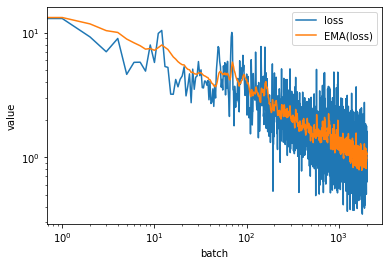

In [25]:
plt.loglog(losses_without_parameter_scaling, label='loss')
plt.loglog(pd.Series(losses_without_parameter_scaling).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [26]:
results = test_model(model=model, n=n, sample_count=iter_count, scale_parameters=False)

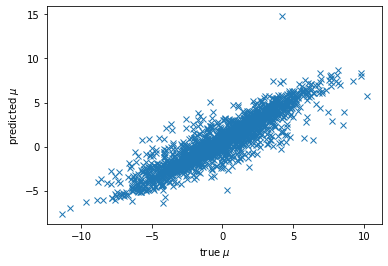

In [27]:
plt.plot(results['true_mu'], results['predicted_mu'], 'x')
plt.xlabel(r'true $\mu$')
plt.ylabel(r'predicted $\mu$');

In [28]:
results['r2_score_mu']

0.752999683227846

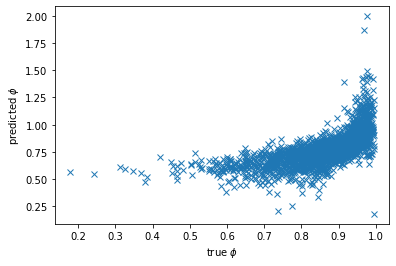

In [29]:
plt.plot(results['true_phi'], results['predicted_phi'], 'x')
plt.xlabel(r'true $\phi$')
plt.ylabel(r'predicted $\phi$');

In [30]:
results['r2_score_phi']

-0.7763380428521485

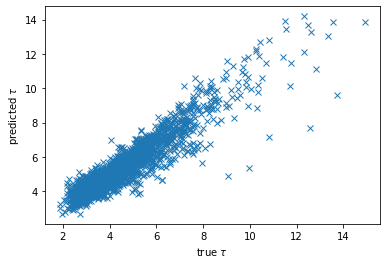

In [31]:
plt.plot(results['true_tau'], results['predicted_tau'], 'x')
plt.xlabel(r'true $\tau$')
plt.ylabel(r'predicted $\tau$');

In [32]:
results['r2_score_tau']

0.6068697163605437

In [33]:
model = keras.models.load_model('model.h5')

In [34]:
losses_with_parameter_scaling = train_model(model=model, n=n, batch_count=iter_count, scale_parameters=True)

1/1 [==============================] - 0s 14ms/step - loss: 0.0027


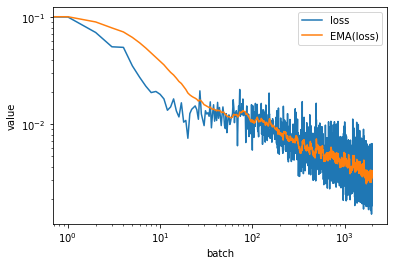

In [35]:
plt.loglog(losses_with_parameter_scaling, label='loss')
plt.loglog(pd.Series(losses_with_parameter_scaling).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [36]:
results = test_model(model=model, n=n, sample_count=iter_count, scale_parameters=True)

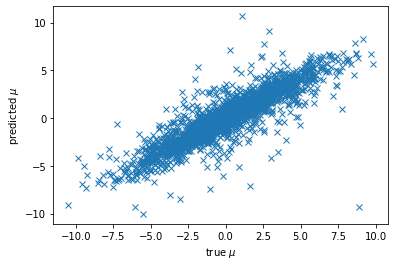

In [37]:
plt.plot(results['true_mu'], results['predicted_mu'], 'x')
plt.xlabel(r'true $\mu$')
plt.ylabel(r'predicted $\mu$');

In [38]:
results['r2_score_mu']

0.7679402962145268

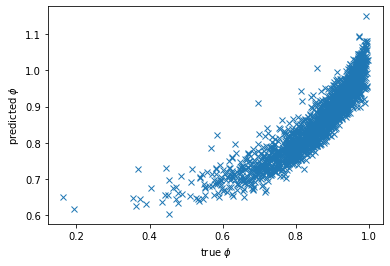

In [39]:
plt.plot(results['true_phi'], results['predicted_phi'], 'x')
plt.xlabel(r'true $\phi$')
plt.ylabel(r'predicted $\phi$');

In [40]:
results['r2_score_phi']

0.8014736528572183

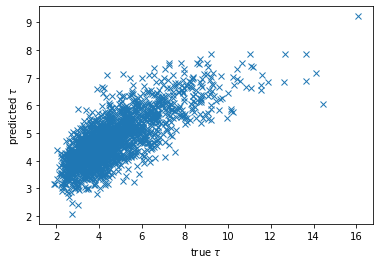

In [41]:
plt.plot(results['true_tau'], results['predicted_tau'], 'x')
plt.xlabel(r'true $\tau$')
plt.ylabel(r'predicted $\tau$');

In [42]:
results['r2_score_tau']

0.518283597280156